In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import parse_mnist

In [3]:
import context
import hier_clust
from collections import defaultdict, Counter

In [4]:
import scipy.cluster.hierarchy as sch

In [5]:
%%time

x_train = parse_mnist.parse_images("./train-images-idx3-ubyte.gz", add_constant = False)
y_train = parse_mnist.parse_labels("./train-labels-idx1-ubyte.gz")

x_test = parse_mnist.parse_images("./t10k-images-idx3-ubyte.gz", add_constant = False)
y_test = parse_mnist.parse_labels("./t10k-labels-idx1-ubyte.gz")

Parsing ./train-images-idx3-ubyte.gz as images
  numImages = 60000
  numRows = 28
  numCols = 28
  Done
Parsing ./train-labels-idx1-ubyte.gz as labels
  numItems = 60000
  Done
Parsing ./t10k-images-idx3-ubyte.gz as images
  numImages = 10000
  numRows = 28
  numCols = 28
  Done
Parsing ./t10k-labels-idx1-ubyte.gz as labels
  numItems = 10000
  Done
CPU times: user 5.54 s, sys: 778 ms, total: 6.32 s
Wall time: 6.33 s


In [6]:
n_obs = 1000
indices = np.arange(len(y_train))
np.random.seed(1)
np.random.shuffle(indices)
x = x_train[indices][:n_obs]
y = y_train[indices][:n_obs]
print(x.shape)
print(y.shape)

(1000, 784)
(1000,)


In [7]:
h_obj = hier_clust.HierClust()

In [8]:
%%time
np.random.seed(1)
tree, _ = h_obj.fit(x)

CPU times: user 4.87 s, sys: 148 ms, total: 5.02 s
Wall time: 5.02 s


In [9]:
trees = dict()
top_down_label = "Top Down"
trees[top_down_label] = tree

In [10]:
def avg_gini_impurity_tree(tree):
    assert "counts" in tree.data
    assert "total_count" in tree.data
    assert "gini_impurity_within_node" in tree.data
    numer = tree.reduce_leaf_data(
        combine = lambda x, y: x + y,
        leaf_func = lambda x: x['gini_impurity_within_node'] * x['total_count'])
    total_count_from_root = tree.data['total_count']
    return numer / float(total_count_from_root)

In [11]:
def avg_gini_impurity_from_assignments(assignments, labels):
    assert len(assignments) == len(labels)
    
    indices_grouped_by_leaf = defaultdict(list)
    for i, a in assignments:
        indices_grouped_by_leaf[a].append(i)
    
    numer = 0.0
    for leaf, indices in indices_grouped_by_leaf.items():
        labels_at_leaf = labels[indices]
        count_by_label = Counter(labels_at_leaf)
        leaf_size = len(labels_at_leaf)
        gini = 0.0
        for label, count in count_by_label.items():
            gini += (count * (leaf_size - count)) / float(leaf_size * leaf_size)
        numer += gini * leaf_size
    return numer / float(len(labels))

In [12]:
assignments_pruned = h_obj._get_assignments(tree.prune(depth=3))
avg_gini_impurity_from_assignments(assignments_pruned, labels=y)

0.5792004438428734

In [13]:
def gini_impurity_single_node(counts):
    '''Turns a Counter object for a single node into Gini impurity'''
    gini = 0.0
    leaf_size = sum(counts.values())
    for label, count in counts.items():
        gini += (count * (leaf_size - count)) / float(leaf_size * leaf_size)
    return gini

def add_counters_to_tree(tree, labels):
    def helper(node):
        if len(node.children) == 0:
            indices = node.data["orig_indices"]
            node.data["counts"] = Counter(labels[i] for i in indices)
        else:
            counts = Counter()
            for c in node.children:
                helper(c)
                counts += c.data["counts"]
            node.data["counts"] = counts
            
        node.data["total_count"] = len(node.data["orig_indices"])
        node.data["gini_impurity_within_node"] = gini_impurity_single_node(node.data["counts"])

    helper(tree)
    return tree

In [14]:
tree = add_counters_to_tree(tree, y)
#print tree.prune(3).str_display()
avg_gini_impurity_tree(tree.prune(3))

0.5792004438428733

In [15]:
def convert_linkage_to_tree(link, labels = None):
    def helper(tree, path):
        data = {
            "orig_indices": [],
            "tree_path": path,
            "dist": tree.dist,
        }
        if tree.is_leaf():
            data["orig_indices"] = [tree.get_id()]
            return hier_clust.tree_util.Tree.leaf(data)
        else:
            left = helper(tree.get_left(), path=path+'L')
            right = helper(tree.get_right(), path=path+'R')
            indices = left.data["orig_indices"] + right.data["orig_indices"]
            data["orig_indices"] = sorted(indices)
            return hier_clust.tree_util.Tree(
                data = data,
                children = [left, right])
        
    root = sch.to_tree(link)
    root = helper(root, '')
    if labels is not None:
        root = add_counters_to_tree(root, labels)
    return root

In [16]:
import timeit
def create_timer():
    start = timeit.default_timer()
    def timer():
        return timeit.default_timer() - start
    return timer

In [17]:
methods = ["single", "average", "complete", "ward"]

for method in methods:
    timer = create_timer()
    print("Starting method: {}".format(method))
    try:
        link = sch.linkage(x, method=method)
    except Exception as e:
        print("Exception during clustering: {}".format(e))
    try:
        trees["BU ({})".format(method)] = convert_linkage_to_tree(link, labels = y)
    except Exception as e:
        print("Exception during post-processing: {}".format(e))
    print("Method '{}' elapsed time: {} seconds".format(method, timer()))

Starting method: single
Method 'single' elapsed time: 0.488140106201 seconds
Starting method: average
Method 'average' elapsed time: 0.763225793839 seconds
Starting method: complete
Method 'complete' elapsed time: 0.802828073502 seconds
Starting method: ward
Method 'ward' elapsed time: 0.731350898743 seconds


In [18]:
def construct_random_tree(indices, path=''):
    if len(indices) == 0:
        raise Exception("Reached leaf with zero elements")
    elif len(indices) == 1:
        return hier_clust.tree_util.Tree.leaf(data=dict(orig_indices=indices, tree_path=path))
    else:
        num_left = int(len(indices) / 2)
        num_right = len(indices) - num_left
        left_mask = np.array([True for i in xrange(num_left)] + [False for i in xrange(num_right)], dtype='bool')
        np.random.shuffle(left_mask)
        ltree = construct_random_tree(indices = indices[left_mask], path = path+'L')
        rtree = construct_random_tree(indices = indices[~left_mask], path = path+'R')
        data = dict(orig_indices = indices, tree_path = path)
        return hier_clust.tree_util.Tree(data = data, children = [ltree, rtree])

In [19]:
%%time
np.random.seed(1)
random_tree = construct_random_tree(indices = np.arange(len(y)))
random_tree = add_counters_to_tree(random_tree, labels=y)
trees["Random 50% split"] = random_tree

CPU times: user 55.7 ms, sys: 5.03 ms, total: 60.7 ms
Wall time: 59.3 ms


BU (average)
BU (complete)
BU (single)
BU (ward)
Random 50% split
Top Down
CPU times: user 2.67 s, sys: 82.5 ms, total: 2.75 s
Wall time: 2.71 s


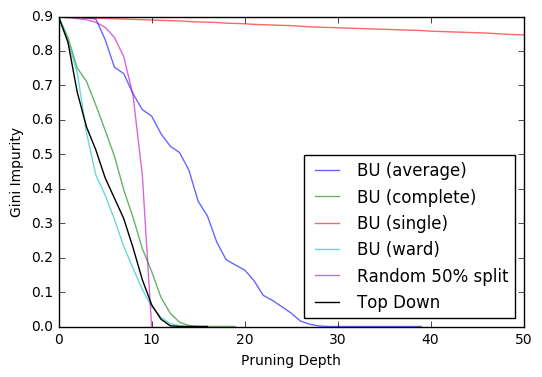

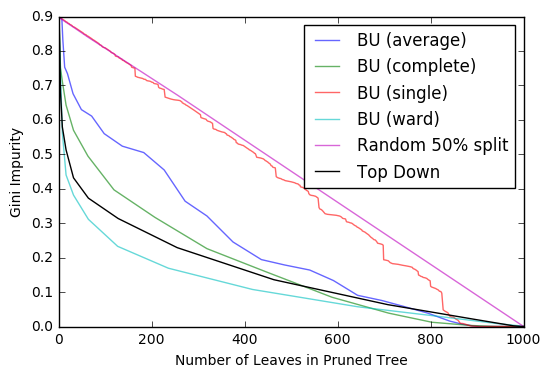

In [20]:
%%time

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
depths = np.arange(n_obs)
for name in sorted(trees.keys()):
    print(name)
    tree = trees[name]
    total_leaves = tree.num_leaves()
    list_num_leaves = []
    impurity = []
    depths_used = []
    for d in depths:
        pruned_tree = tree.prune(depth = d)
        impurity.append(avg_gini_impurity_tree(pruned_tree))
        num_leaves = pruned_tree.num_leaves()
        list_num_leaves.append(num_leaves)
        depths_used.append(d)
        if num_leaves == total_leaves:
            break
    if name == top_down_label:
        kw = dict(alpha=1.0, color='black')
    else:
        kw = dict(alpha = 0.6)
    ax1.plot(depths_used, impurity, label=name, **kw)
    ax2.plot(list_num_leaves, impurity, label=name, **kw)

ax1.legend(loc='best')
ax1.set_ylabel('Gini Impurity')
ax1.set_xlabel('Pruning Depth')
ax1.set_xlim(0, 50)

ax2.legend(loc='best')
ax2.set_ylabel('Gini Impurity')
ax2.set_xlabel('Number of Leaves in Pruned Tree')

None

Note: Certain linkage methods (esp single and average) tend to produce lopsided trees

TODO: Need to make sure that `avg_gini_impurity` sensibly handles lopsided trees (instead of producing misleadingly low impurity).

Also, this highlights a drawback of the top-down hierarchical clustering approach: in contrast to bottom-up clustering, it does not support pruning to a target number of leaves.  To do so requires some notion of "distance" at each split (this distance metric serves as a tie-breaker when deciding which node to split next).  Consequently, the top-down approach only lets us prune to a target depth, not to a target number of leaves.

### Notes on results (3/2/17):

Top-down hierarchical clustering:
* 1000 observations - 5 sec
* 5000 observations - 55 sec
* 10000 observations - 145 sec
* 60000 observations - 1780 sec

Bottom-up hierarchical clustering ("average" linkage):
* 1000 observations - 1 sec
* 5000 observations - 50 sec
* 10000 observations - 360 sec
* 60000 observations - error (apparently due to an integer overflow)

In [21]:
def random_leaf_impurity(labels):
    ''' Calculate the impurity-vs-depth curve for a tree that
        randomly peels off a single observation at each layer'''
    N = len(labels)
    depths = np.arange(N)
    impurity = []
    unique_labels = np.unique(labels)
    count_by_label = Counter(labels)
    cumulative_count_by_label = Counter()
    for d in depths:
        numer = 0.0
        for k in unique_labels:
            Nk = count_by_label[k]
            ck = cumulative_count_by_label[k]
            numer += (Nk - ck) * (N - d - Nk + ck)
        imp = numer / float((N - d) * N)
        impurity.append(imp)
        cumulative_count_by_label[labels[d]] += 1
    return depths, np.asarray(impurity)

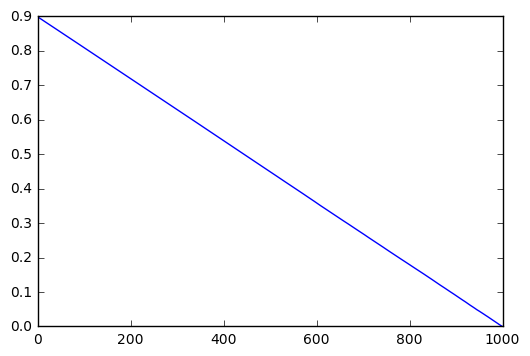

In [22]:
depths, impurity = random_leaf_impurity(y)
plt.plot(depths, impurity)
None